In [1]:
import bayesflow.diagnostics as diag
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import (InvertibleNetwork, SequenceNetwork, 
                                SetTransformer, DeepSet)
from bayesflow.summary_networks import HierarchicalNetwork
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.trainers import Trainer, SimulationDataset

import tensorflow as tf

import numpy as np
import pickle
from src.SlovotvirModelM import run_model_parallel
import matplotlib.pyplot as plt
import seaborn as sns

import arviz as az
from tabulate import tabulate
from sklearn.decomposition import PCA
import umap

/opt/homebrew/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
num_params = 3
epochs = 300
batch_size = 32
learning_rate = 0.001

train_size = 40000
test_size = 4000
valid_size = 4000

RNG = np.random.default_rng(2023)

### 0. Functions and other supplements

In [3]:
# NB: PRIOR MEANS AND STD SHOULD BE THE SAME ACROSS THE BOARD

def configure_input(forward_dict):
    """Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """

    # Prepare placeholder dict
    out_dict = {}

    # Convert data to logscale
    logdata = np.log1p(forward_dict["sim_data"]).astype(np.float32)

    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict["prior_draws"].astype(np.float32)
    # compute prior means and stds
    # prior_means = np.mean(params, axis=0)
    # prior_stds = np.std(params, axis=0)
    # z-standardize
    params = (params - prior_means) / prior_stds

    # Add to keys
    out_dict["summary_conditions"] = logdata
    out_dict["parameters"] = params

    out_dict["summary_conditions"] = np.expand_dims(out_dict["summary_conditions"], axis=2)

    return out_dict

In [4]:
# def binning(likes, bins=100):
#     likes = likes[:len(likes) - len(likes) % bins]
#     likes = likes.reshape(-1, bins).sum(axis=1)
#     return likes

def binning(likes):
    # Determine the number of bins based on the length of the likes array
    num_bins = int(np.ceil(np.log2(len(likes))))
    
    # Define bin edges at powers of 2 based on the indexes of likes
    bin_edges = 2 ** np.arange(num_bins + 1)
    
    # Assign values to bins
    bin_indices = np.digitize(np.arange(len(likes)), bin_edges)
    
    # Calculate the sum of values in each bin
    bin_sums = np.bincount(bin_indices, weights=likes, minlength=num_bins + 1)
    
    return bin_sums

### 1. Generating training and testing data

In [5]:
# training_params = (np.random.uniform(0, 10, train_size), np.random.uniform(0, 10, train_size), np.random.lognormal(0, 0.5, train_size))
# testing_params = (np.random.uniform(0, 10, test_size), np.random.uniform(0, 10, test_size), np.random.lognormal(0, 0.5, test_size))
# validation_params = (np.random.uniform(0, 10, valid_size), np.random.uniform(0, 10, valid_size), np.random.lognormal(0, 0.5, valid_size))

In [6]:
# prior_means = np.mean(training_params, axis=1)
# prior_stds = np.std(training_params, axis=1)

In [7]:
# training_data = run_model_parallel(training_params[0], training_params[1], training_params[2], train_size)

In [8]:
# testing_data = run_model_parallel(testing_params[0], testing_params[1], testing_params[2], test_size)

In [9]:
# validation_data = run_model_parallel(validation_params[0], validation_params[1], validation_params[2], valid_size)

In [10]:
# training_params = np.vstack(training_params)
# testing_params = np.vstack(testing_params)
# validation_params = np.vstack(validation_params)

In [11]:
# train_data = {}
# train_data["prior_non_batchable_context"] = None
# train_data["prior_batchable_context"] = None
# train_data["prior_draws"] = training_params.reshape(num_params, train_size).T
# train_data["sim_non_batchable_context"] = None
# train_data["sim_batchable_context"] = None
# train_data["sim_data"] = np.array(training_data, dtype = float)


# test_data = {}
# test_data["prior_non_batchable_context"] = None
# test_data["prior_batchable_context"] = None
# test_data["prior_draws"] = testing_params.reshape(num_params, test_size).T
# test_data["sim_non_batchable_context"] = None
# test_data["sim_batchable_context"] = None
# test_data["sim_data"] = np.array(testing_data, dtype = float)

# valid_data = {}
# valid_data["prior_non_batchable_context"] = None
# valid_data["prior_batchable_context"] = None
# valid_data["prior_draws"] = validation_params.reshape(num_params, valid_size).T
# valid_data["sim_non_batchable_context"] = None
# valid_data["sim_batchable_context"] = None
# valid_data["sim_data"] = np.array(validation_data, dtype = float)

In [12]:
# pickle.dump(train_data, open("data/train_data_1205.pkl", "wb"))
# pickle.dump(test_data, open("data/test_data_1205.pkl", "wb"))
# pickle.dump(valid_data, open("data/valid_data_1205.pkl", "wb"))
# load data
train_data = pickle.load(open("data/train_data_1105.pkl", "rb"))
test_data = pickle.load(open("data/test_data_1105.pkl", "rb"))
valid_data = pickle.load(open("data/valid_data_1105.pkl", "rb"))

In [13]:
train_data_ = pickle.load(open("data/train_data_1205.pkl", "rb"))
test_data_ = pickle.load(open("data/test_data_1205.pkl", "rb"))
valid_data_ = pickle.load(open("data/valid_data_1205.pkl", "rb"))

In [14]:
# train_data["sim_data"].shape
train_data_["sim_data"] = np.array(list(map(binning, train_data_["sim_data"])))
test_data_["sim_data"] = np.array(list(map(binning, test_data_["sim_data"])))
valid_data_["sim_data"] = np.array(list(map(binning, valid_data_["sim_data"])))

In [15]:
# combine sim_data and prior_draws
train_data["sim_data"] = np.concatenate((train_data["sim_data"], train_data_["sim_data"]))
train_data["prior_draws"] = np.concatenate((train_data["prior_draws"], train_data_["prior_draws"]))
test_data["sim_data"] = np.concatenate((test_data["sim_data"], test_data_["sim_data"]))
test_data["prior_draws"] = np.concatenate((test_data["prior_draws"], test_data_["prior_draws"]))
valid_data["sim_data"] = np.concatenate((valid_data["sim_data"], valid_data_["sim_data"]))
valid_data["prior_draws"] = np.concatenate((valid_data["prior_draws"], valid_data_["prior_draws"]))

In [16]:
# # apply binning to each entry in sim_data using map
# train_data["sim_data"] = np.array(list(map(binning, train_data["sim_data"])))
# test_data["sim_data"] = np.array(list(map(binning, test_data["sim_data"])))
# valid_data["sim_data"] = np.array(list(map(binning, valid_data["sim_data"])))

In [17]:
prior_means = np.mean(train_data["prior_draws"], axis=0)
prior_stds = np.std(train_data["prior_draws"], axis=0)

In [18]:
train_data['sim_data'].shape

(80000, 17)

### 2. Training the model

In [19]:
summary_net = DeepSet(summary_dim=4)

In [20]:
inference_net = InvertibleNetwork(num_params=num_params, num_coupling_layers=4)

In [21]:
amortizer = AmortizedPosterior(inference_net, summary_net, name="slovotvir_amortizer")

In [22]:
trainer = Trainer(amortizer=amortizer, 
                  configurator=configure_input, 
                  memory=True)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


In [23]:
schedule = tf.keras.optimizers.schedules.CosineDecay(learning_rate, epochs * SimulationDataset(train_data, batch_size).num_batches, 
                                                     name = "lr_decay")
optimizer = tf.keras.optimizers.legacy.Adam(schedule, global_clipnorm = 1)

In [24]:
#run training and save
history = trainer.train_offline(simulations_dict = train_data, epochs = epochs, 
                                batch_size = batch_size, optimizer = optimizer, 
                                validation_sims = test_data,
                                early_stopping=True, patience=20)
trainer._save_trainer("model")

Training epoch 1:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 1.386


Training epoch 2:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 1.003


Training epoch 3:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 1.764


Training epoch 4:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 0.937


Training epoch 5:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 0.801


Training epoch 6:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 0.539


Training epoch 7:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 0.276


Training epoch 8:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 0.032


Training epoch 9:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 0.492


Training epoch 10:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: -0.019


Training epoch 11:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 0.007


Training epoch 12:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 0.141


Training epoch 13:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: -0.351


Training epoch 14:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: -0.724


Training epoch 15:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: -0.703


Training epoch 16:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: -0.496


Training epoch 17:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: -0.647


Training epoch 18:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: -0.671


Training epoch 19:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: -0.925


Training epoch 20:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: -0.894


Training epoch 21:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: -1.054


Training epoch 22:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: -0.797


Training epoch 23:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: -0.779


Training epoch 24:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: -1.099


Training epoch 25:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: -0.530


Training epoch 26:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: -0.333


Training epoch 27:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: -1.039


Training epoch 28:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: -1.138


Training epoch 29:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: -0.749


Training epoch 30:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: -1.118


Training epoch 31:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: -1.051


Training epoch 32:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: -1.080


Training epoch 33:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: -1.168


Training epoch 34:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: -0.758


Training epoch 35:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: -1.351


Training epoch 36:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: -1.288


Training epoch 37:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: -1.264


Training epoch 38:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: -0.964


Training epoch 39:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: -1.032


Training epoch 40:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: -0.976


Training epoch 41:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: -0.991


Training epoch 42:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: -1.329


Training epoch 43:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: -1.226


Training epoch 44:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: -1.323


Training epoch 45:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: -1.481


Training epoch 46:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: -1.075


Training epoch 47:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: -0.979


Training epoch 48:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: -1.309


Training epoch 49:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: -1.275


Training epoch 50:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: -1.453


Training epoch 51:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: -0.909


Training epoch 52:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: -1.300


Training epoch 53:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: -1.400


Training epoch 54:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: -1.407


Training epoch 55:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: -1.079


Training epoch 56:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: -1.402


Training epoch 57:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: -1.539


Training epoch 58:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: -1.443


Training epoch 59:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: -1.535


Training epoch 60:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: -1.445


Training epoch 61:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: -1.401


Training epoch 62:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: -1.001


Training epoch 63:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: -1.488


Training epoch 64:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: -1.465


Training epoch 65:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: -1.462


Training epoch 66:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: -1.079


Training epoch 67:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: -1.194


Training epoch 68:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: -1.477


Training epoch 69:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: -1.328


Training epoch 70:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: -1.531


Training epoch 71:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: -1.504


Training epoch 72:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: -1.576


Training epoch 73:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: -1.481


Training epoch 74:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: -1.386


Training epoch 75:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: -1.583


Training epoch 76:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: -1.633


Training epoch 77:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: -1.682


Training epoch 78:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: -1.582


Training epoch 79:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: -1.606


Training epoch 80:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: -1.654


Training epoch 81:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: -1.717


Training epoch 82:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: -1.481


Training epoch 83:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: -1.465


Training epoch 84:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: -1.707


Training epoch 85:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: -1.392


Training epoch 86:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: -1.768


Training epoch 87:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: -1.644


Training epoch 88:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: -1.295


Training epoch 89:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: -1.635


Training epoch 90:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: -1.555


Training epoch 91:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: -1.737


Training epoch 92:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: -1.629


Training epoch 93:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: -1.661


Training epoch 94:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: -1.688


Training epoch 95:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: -1.205


Training epoch 96:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: -1.667


Training epoch 97:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: -1.694


Training epoch 98:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: -1.491


Training epoch 99:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: -1.574


Training epoch 100:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: -1.696


Training epoch 101:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 101, Loss: -1.687


Training epoch 102:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 102, Loss: -1.735


Training epoch 103:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 103, Loss: -1.775


Training epoch 104:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 104, Loss: -1.821


Training epoch 105:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 105, Loss: -1.718


Training epoch 106:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 106, Loss: -1.860


Training epoch 107:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 107, Loss: -1.617


Training epoch 108:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 108, Loss: -1.744


Training epoch 109:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 109, Loss: -1.816


Training epoch 110:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 110, Loss: -1.809


Training epoch 111:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 111, Loss: -1.617


Training epoch 112:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 112, Loss: -1.760


Training epoch 113:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 113, Loss: -1.740


Training epoch 114:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 114, Loss: -1.906


Training epoch 115:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 115, Loss: -1.705


Training epoch 116:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 116, Loss: -1.720


Training epoch 117:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 117, Loss: -1.845


Training epoch 118:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 118, Loss: -1.849


Training epoch 119:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 119, Loss: -1.866


Training epoch 120:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 120, Loss: -1.867


Training epoch 121:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 121, Loss: -1.825


Training epoch 122:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 122, Loss: -1.769


Training epoch 123:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 123, Loss: -1.799
INFO:root:Early stopping triggered.


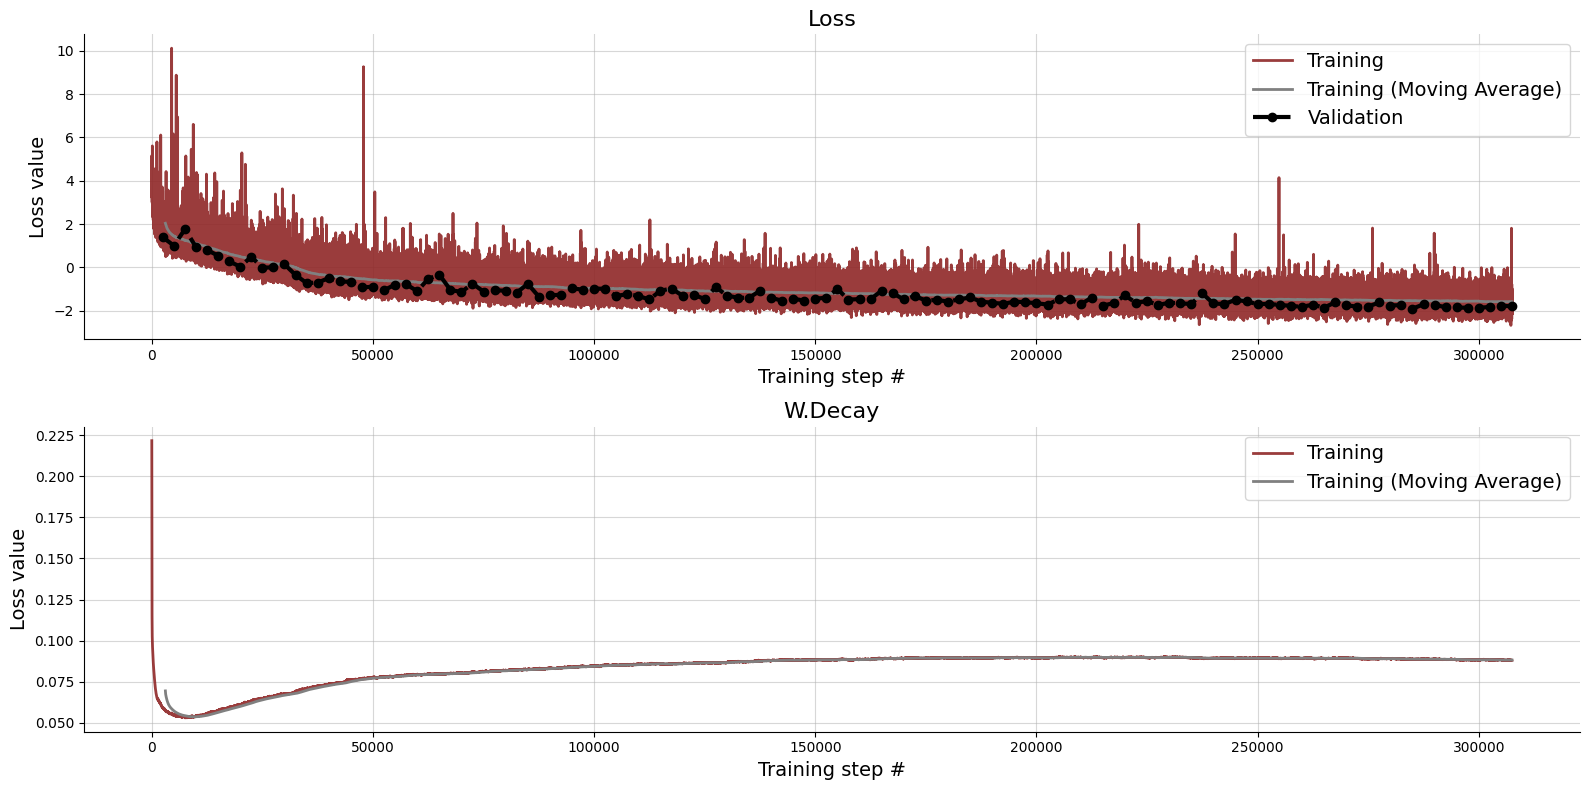

In [26]:
f = diag.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

### 3. Model analysis

In [27]:
# Generate some validation data
validation_sims = trainer.configurator(valid_data) 
# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=1000)
# Revert z-standardization
# post_samples = prior_means + post_samples * prior_stds

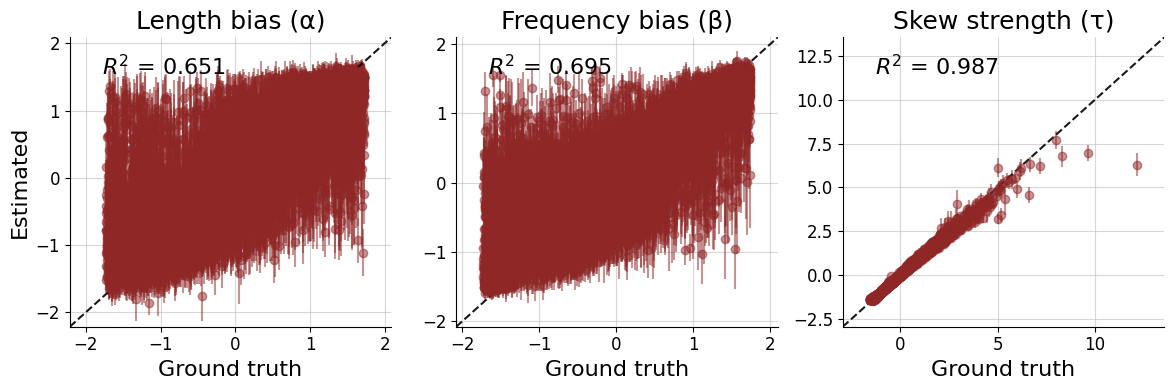

In [28]:
fig = diag.plot_recovery(post_samples, validation_sims["parameters"], add_corr=False,
                         param_names=['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)'])

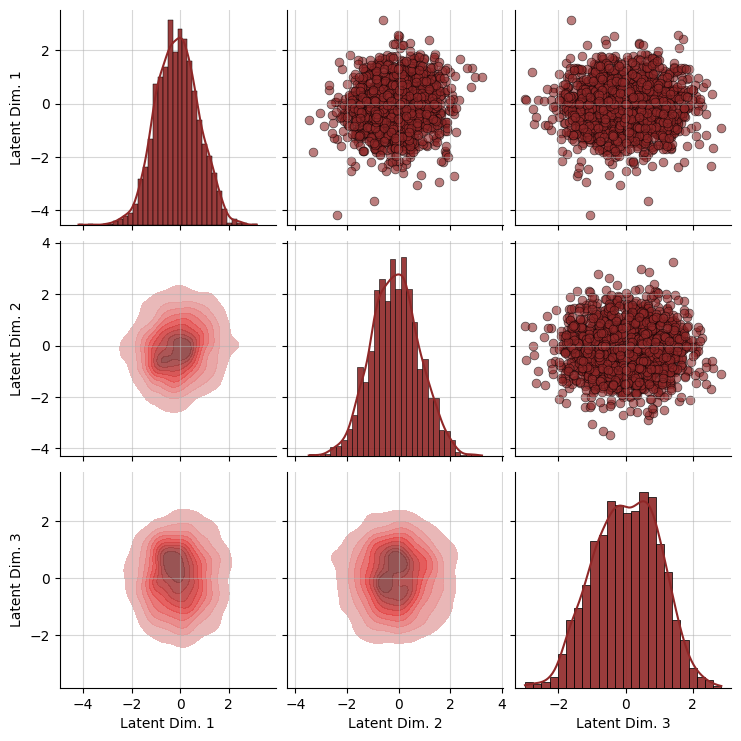

In [29]:
f = trainer.diagnose_latent2d()

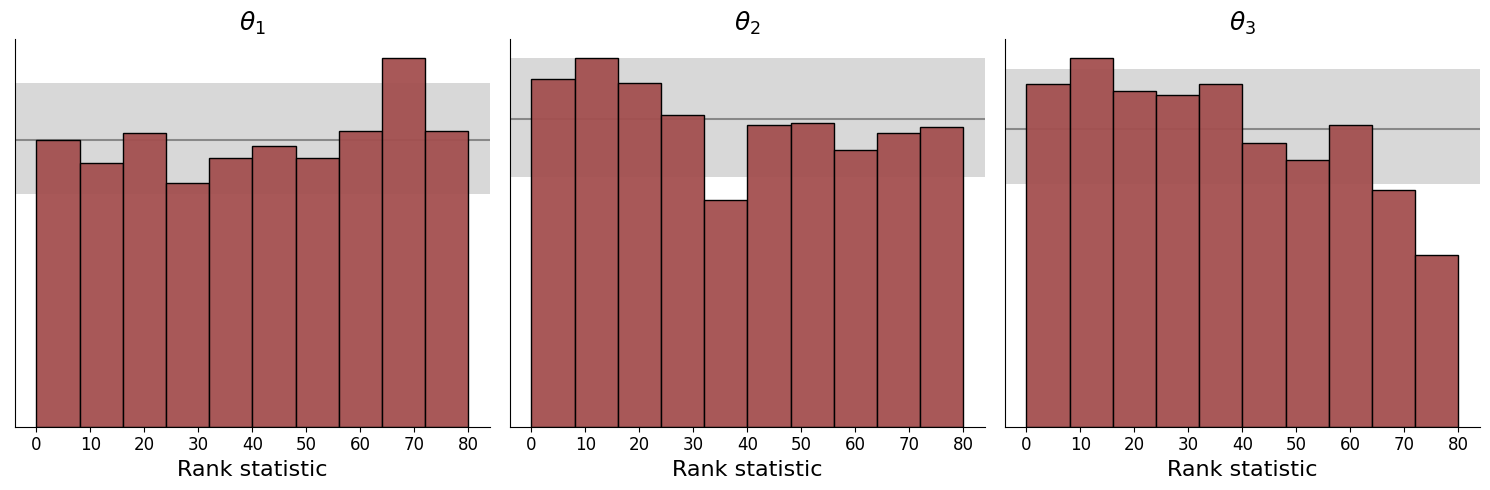

In [30]:
f = trainer.diagnose_sbc_histograms()

### 4. Posterior analysis

In [53]:
a = 0
b = 10
tau = 2

In [54]:
fake_dist = run_model_parallel([a], [b], [tau], 1)
# apply binning to each entry in sim_data using map
fake_dist = np.array(list(map(binning, fake_dist)))

In [55]:
fake_dist[0].sum()

129974.0

In [56]:
fake_dist[0].shape

(17,)

In [57]:
obs_data = np.log1p(fake_dist[0])[np.newaxis, :, np.newaxis].astype(np.float32)

In [58]:
# Obtain 500 posterior draws given real data
post_samples_ = amortizer.sample({"summary_conditions": obs_data}, 10000)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples_ = prior_means + post_samples_ * prior_stds

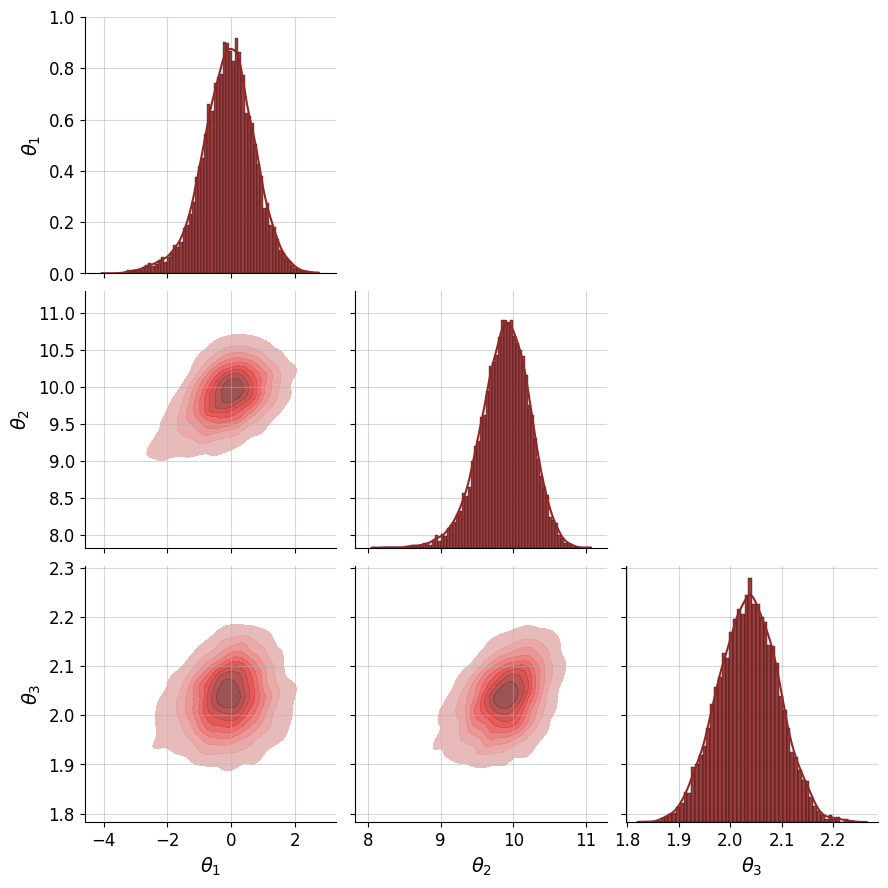

In [59]:
f = diag.plot_posterior_2d(post_samples_)

In [60]:
ps = ['α', 'β', 'τ']
table_data = []
for _ in range(3):
    row = [ps[_], np.mean(post_samples_[:, _]).round(3), az.hdi(post_samples_[:, _], hdi_prob=0.95).round(3)]
    table_data.append(row)

table_headers = ['Parameter', 'Mean', 'HDI']
latex_table = tabulate(table_data, headers=table_headers, tablefmt='latex')
print(latex_table)

\begin{tabular}{lrl}
\hline
 Parameter   &   Mean & HDI             \\
\hline
 α           & -0.103 & [-1.821  1.521] \\
 β           &  9.883 & [ 9.194 10.54 ] \\
 τ           &  2.035 & [1.925 2.152]   \\
\hline
\end{tabular}


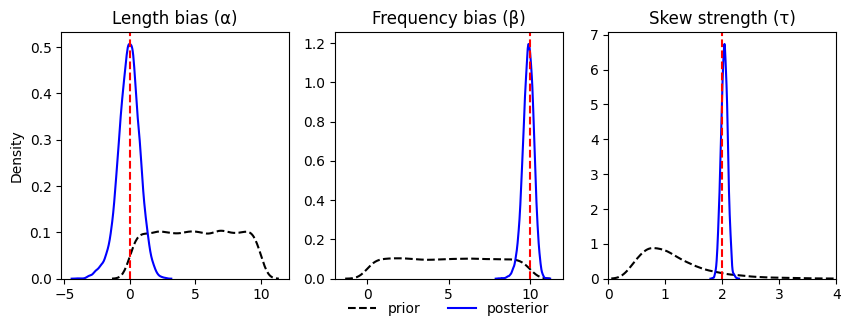

In [61]:
from matplotlib import lines


fig, axs = plt.subplots(1, 3, figsize=(10, 3.2))

# Plot prior density
sns.kdeplot(np.random.uniform(0, 10, 10000), 
            ax=axs[0], color='black', linestyle='--')
sns.kdeplot(np.random.uniform(0, 10, 10000), 
            ax=axs[1], color='black', linestyle='--')
sns.kdeplot(np.random.lognormal(0, sigma=0.5, size=10000), 
            ax=axs[2], color='black', linestyle='--')

# Plot posterior density
sns.kdeplot(post_samples_[:, 0], ax=axs[0], color='blue')
sns.kdeplot(post_samples_[:, 1], ax=axs[1], color='blue')
sns.kdeplot(post_samples_[:, 2], ax=axs[2], color='blue')

# plot true values
axs[0].axvline(a, color='red', linestyle='--')
axs[1].axvline(b, color='red', linestyle='--')
axs[2].axvline(tau, color='red', linestyle='--')

# remove y axis labels
axs[0].set_ylabel('Density')
axs[2].set_ylabel('')
axs[1].set_ylabel('')

# Set xlim for [2] to 0, 4
axs[2].set_xlim(0, 4)

# Set titles
titles_ = ['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)']
for i, ax in enumerate(axs):
    ax.set_title(titles_[i])

# Add legend below the subplots
plt.legend(['prior', 'posterior'], 
           bbox_to_anchor=(-0.7, -0.2),
             loc='lower center', ncol=3,
             frameon=False)

# # Save to pdf
# plt.savefig('figures/posterior.pdf', bbox_inches='tight', pad_inches=0)

# Show the plot
plt.show()

In [62]:
# Perform PCA
pca = PCA(n_components=2, whiten=True)
pca_result = pca.fit_transform(train_data['sim_data'])

true_hist = obs_data.reshape(1, -1)
pca_true = pca.transform(true_hist)

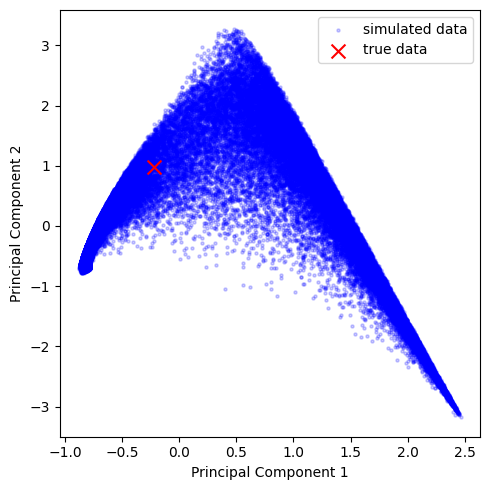

In [63]:
# Plot PCA
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
            s=5, color = 'blue', 
            alpha=0.2, label='simulated data')
plt.scatter(pca_true[:, 0], pca_true[:, 1],
             s=100, color='red', marker='x', 
             label='true data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()
plt.savefig('figures/pca.pdf', bbox_inches='tight', pad_inches=0)
plt.show()